# Correlation Data Analysis

In this notebook, I will include all required steps to analyze the correlation $C_l$ of CMB potential field and the DES overdensity field. In Section I I will analyze CMB potential data, then perform the analysis of DES data in Section II and III. Following is the correlated $C_l$ calculation and error estimation in Section IV. 

## I. CMB Data Preparation
In this part I will use provided CMB potential map and prepare the $C_l$ for Section IV. 
### Loading library
First of all, I need to import required Python library for the analysis:
* Use `healpy` package for all-sky data visualization and $C_l$ calculation. It is the python package of Healpix pixelization scenario
* Use `pandas` package to handle FITS table data. Note that `pandas` is widely used by Data Science and one can effectively finish large dataset handling tasks with its build-in functions. In 2019 I used it to handle billions of data and it works well in the work station. 

In [1]:
import numpy as np
import healpy as hp
import pandas as pd
#from orphics import io, catalogs, stats

### Loading Data Files

I was provided a CMB potential file and a mask file. The all-sky data is presented in the expansion of spherical harmonics,
\begin{equation}
f(\hat{n}) = \sum_{l,m}a_{lm}Y_{lm}
\end{equation}
and the data file gives us $a_{lm}$ of signal (and mask?). Using the build-in function of `healpy`, we can read the $a_lm$ data from the files. Note that the value of mask file is either 0 or 1, which mean that the data point at certain Healpix bin is ignored or considered. 

In [2]:
alm = hp.read_alm('./COM_Lensing_4096_R3.00/MV/dat_klm.fits')
mask = hp.read_map('./COM_Lensing_4096_R3.00/mask.fits.gz')
masknan = hp.read_map('./COM_Lensing_4096_R3.00/mask.fits.gz')

We also apply a filter to the $a_{lm}$ but here the given filter doesn't change anything. The `hp.almxfl` function will output the product of (1) $a_{lm}$ and (2)$f(l)$, a function of $l$. 

In [3]:
def filter(alm,lmax):
    fl = np.ones(lmax)
    #ells = np.arange(fl.size)
    return hp.almxfl(alm,fl)

After apply the filter we could visualize the data and get a new $a_{lm}$. Note that 
* here we set the resolution of the map with $N_{\rm side} = 2048$
* For those data point ignored by the mask, I set the value of them to `np.nan` only for the visualization purpose (since the impact of setting `np.nan` on $a_{lm}$ is unknown)
* I include some visualization setting in the `mollview` function

The new $a_{lm}$ would be used to obtain $C_{l}$.

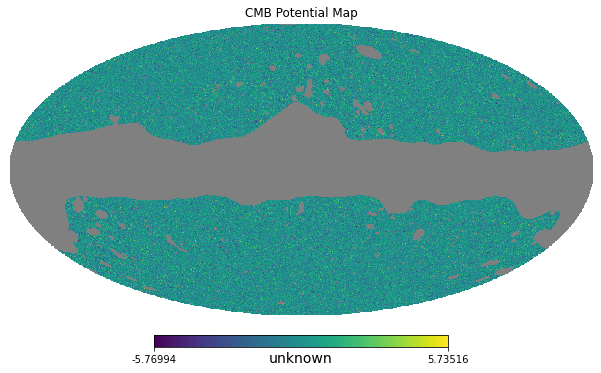

In [4]:
masknan[masknan == 0] = np.nan
pmap = hp.alm2map(filter(alm,2048),nside=2048)*mask
hp.mollview(pmap*masknan, 
            title = 'CMB Potential Map',
            #cmap = 'rainbow',
            #min = -2.0,
            #max = 2.0,
            unit = 'unknown'
           )
del masknan
lmax = 500
del alm
alm = hp.map2alm(pmap,lmax=lmax)
del pmap

## II. DES Data Preparation
In this part I will use provided DES galaxies catalog to produce the overdensity $C_{l}$ for future analysis.
### Loading library
First of all, I need to import a new required Python library for the analysis:
* I use `astropy` package to read FITS table, coordinate transformation and other astronomical calculations.  

### Loading Data Files

I was provided a catalog of galaxies and the FITS table contains following information of each galaxy,
* The equatorial coordinate in column 'RA' and 'DEC', in the unit of degree, range from (0,360) and (-90,90), respectively
* Other information, not required for current stage

In [5]:
from astropy.io import fits
hdul = fits.open('./y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5-10.fit')
ras = hdul[1].data['RA']
decs = hdul[1].data['Dec']

# The Column names are: 
# 'COADD_OBJECTS_ID'
# 'RA      '           
# 'DEC     '           
# 'REDMAGICFLAG'       
# 'ZMAG    '           
# 'ZMAG_ERR'           
# 'MODEL_MAG'          
# 'MODEL_MAGERR'       
# 'MABS    '           
# 'MABS_ERR'           
# 'ZLUM    '           
# 'ZREDMAGIC'          
# 'ZREDMAGIC_E'        
# 'CHISQ   '           
# 'ZSPEC   

I will use `pandas.DataFrame` to store the Galactic coordinate (l, b), instead of Equatorial coordinate (RA, DEC), of each galaxy and use the methods of `pandas.DataFrame` for data analysis in following sections. The coordinate transformation is done by the build-in function of `astropy`. The Galactic longitude data is in radian with the range (0, 2pi); the Galactic latitude data is in degree with the range (-90, 90)

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord
eqo = SkyCoord(ra = ras*u.degree, dec=decs*u.degree, frame='fk5') # Convert to J2000 frame with degree
gal = eqo.transform_to('galactic')
df = pd.DataFrame({'l': gal.l.radian, 'b': gal.b.degree})
df.head()

,l,b
0,2.517010,-55.435994
1,2.521577,-55.452807
2,2.515546,-55.419155
3,2.519834,-55.263704
4,2.516472,-55.412652


In [7]:
del hdul
del ras
del decs

## III. Getting (Number) Overdensity 

The overdensity of number counts in every Healpix pixel can be simply estimated by
\begin{equation}
\delta_i = \frac{n_{i} - \bar{n}}{\bar{n}}
\end{equation}
where $n_i$ is the total number of galaxies of pixel $i$, $\bar{n}$ is the average number of galaxies (average over all pixels with valid data, NOT average for the full sky), and $\delta_i$ is the overdensity of each Healpix pixel. 

In order to obtain the overdensity, $\delta_i$, in one Healpix pixel, we need to 
### Step 1 - Coordinate Transformation
Transfer the Galactic coordinate of each galaxy to spherical coordinate. The reason is illustrated in Step 2. The transformatio I do is to transfer the Galactic coordinate $b$ (in degree) to spherical coordinate $\theta$ in radian, \begin{equation} \theta = (90 - b) * \frac{2\pi}{360} \end{equation}

In [8]:
df['b'] = (90 - df['b'])*2*np.pi/360

### Step 2 - Assign the pixel number
Assign the pixel number to each galaxy. Healpix has already divided the full sky into a number of pixels and provided a pixel number to every pixel at a certain position. I use the `healpy.ang2pix` function to get the pixel number corresponding to the position of each galaxy. Note that `healpy.ang2pix` function can only get the pixel number from given spherical coordinate $(\theta, \phi)$ rather than Galactic coordinate, so I need to convert Galactic coordinate to spherical coordinate beforehand. 

In [9]:
df['hp_pix'] = hp.ang2pix(nside = 256, theta = df['b'].values, phi = df['l'])

### Step 3 - Calculate $n$
Calculate the total number of galaxies in the same Healpix pixel. Before the grouping, we need to add count = 1, the count of each galaxy. 

In [10]:
df['count'] = 1

Adopting `DataFrame.groupby.count` method we could group galaxies with same Healpix pixel number together (the `groupby` part) and count the total number in each group (the `count` part). Note that the `count` function calculate the count of every columns in the dataframe for each group, but we can simply ignore other columns and focus only on the 'count' column

In [11]:
delta = df.groupby('hp_pix').count().reset_index()
del df
delta.head()

,hp_pix,l,b,count
0,532618,2,2,2
1,532619,6,6,6
2,532620,3,3,3
3,533642,4,4,4
4,533643,20,20,20


### Step 4 - Calculate Averaged Galaxy Number
Note that $\bar{n}$ average over all pixels with valid data, NOT average for the full sky. In the table shown above, it only contains Healpix pixel with galaxy counts. So $\bar{n}$ can be simply done by the `mean` function, calculating the average number of given column.

In [12]:
nbar = delta['count'].mean()
nbar

25.38663610719323

### Step 5 - Calculate Overdensity
The overdensity of each pixel is given by
\begin{equation}
\delta_i = \frac{n_{i} - \bar{n}}{\bar{n}}
\end{equation}

In [13]:
delta['overdensity'] = (delta['count'] - nbar)/nbar

### Step 6 - Visualize the Overdensity
Healpix could use its build-in function `mollview` to visualize the all-sky map. Before using the `mollview`, one need to include those pixels with no data point. To get an array with all Healpix pixel, I create an empty dataframe with no data for all Healpix pixel for $N_{\rm side} = 2048$. 

In [14]:
tmp = pd.DataFrame(columns = ['hp_pix', 'count', 'overdensity'])
tmp['hp_pix'] = np.arange(hp.nside2npix(256))
tmp.head()

,hp_pix,count,overdensity
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,NaN
4,4,NaN,NaN


To take all observed data into consideration, I use `DataFrame.merge` method to combine the dataframe with overdensity data, and the empty dataframe. One of the output column contains overdensity data for some of all Healpix pixels, and NaN data for other pixels. The full sky map is also shown.

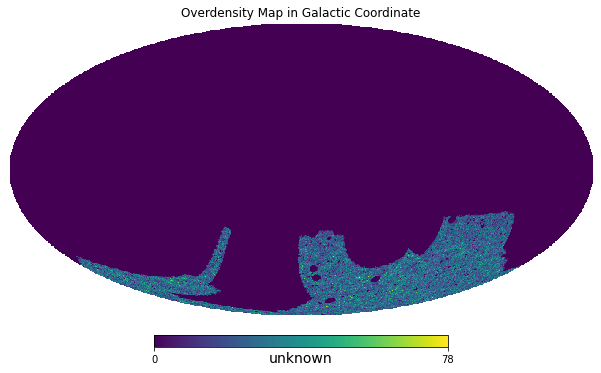

In [15]:
tmp0 = tmp.merge(delta, 'outer', on = 'hp_pix')
hp.mollview(tmp0['count_y'].fillna(0).values,
            title = 'Overdensity Map in Galactic Coordinate',
            #cmap = 'rainbow',
            #min = -2.0,
            #max = 2.0,
            unit = 'unknown'
           )
del tmp

### Visualization of Overdensity - Equatorial coordinate
Redo Step 1 to Step 6 for Equatorial coordinate, I also obtain the corresponding overdensity all-sky map.

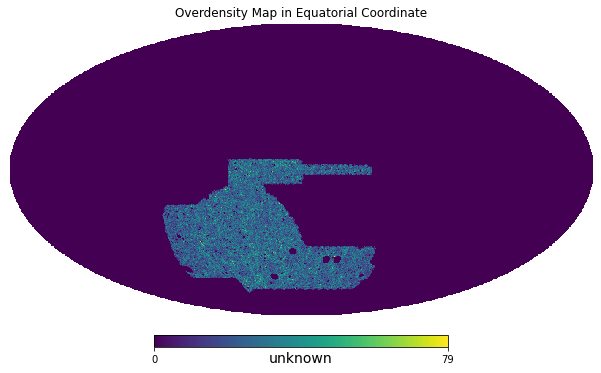

In [16]:
df0 = pd.DataFrame({'l': eqo.ra.radian, 'b': eqo.dec.degree})
df0['b'] = (90 - df0['b'])*2*np.pi/360
df0['hp_pix'] = hp.ang2pix(nside = 256, theta = df0['b'].values, phi = df0['l'])
df0['count'] = 1
delta0 = df0.groupby('hp_pix').count().reset_index()
delta0['overdensity'] = (delta0['count'] - delta0['count'].mean())/delta0['count'].mean()
Tmp = pd.DataFrame(columns = ['hp_pix', 'count', 'overdensity'])
Tmp['hp_pix'] = np.arange(hp.nside2npix(256))
Tmp0 = Tmp.merge(delta0, 'outer', on = 'hp_pix')
hp.mollview(Tmp0['count_y'].fillna(0).values,
            title = 'Overdensity Map in Equatorial Coordinate',
            #cmap = 'rainbow',
            #min = -2.0,
            #max = 2.0,
            unit = 'unknown'
           )

In [17]:
del Tmp
del Tmp0
del df0
del eqo
del delta0

#### Step 1 - The Sky Fraction
The sky fraction here should be obtained from the total pixel numbers with valid cross-$C_l$. I firstly convert the mask file to coordinate using `pix2ang` function, and find out the pixel number with value 1 using `ang2pix` function

In [18]:
pixel = np.arange(hp.nside2npix(2048))
theta0, phi0 =  hp.pix2ang(nside = 2048, ipix = pixel[mask==1])
cmbpix = hp.ang2pix(256, theta0, phi0)
del mask

Then compare the CMB potential pixel number with pixel number with valid overdensity, we could get sky region that have both CMB potential and overdensity.

In [19]:
cmbtmp = pd.DataFrame(columns = ['hp_pix'])
cmbtmp['hp_pix'] = np.unique(cmbpix)
f_sky = len(cmbtmp.merge(delta, 'inner', on = 'hp_pix'))/hp.nside2npix(256)
f_sky

0.12025705973307292

In [20]:
del cmbtmp
del cmbpix
del pixel
del theta0
del phi0

## IV. Correlated $C_l$
Given the CMB potential and overdensity data, we can calculate the cross-spectra via `alm2cl` function. Firstly, I convert DES overdensity data to $a_{lm}$ with same $l=500$. 

In [21]:
lmax = 500
galm = hp.map2alm(tmp0['count_y'].fillna(0).values, lmax = lmax)
kCls = hp.alm2cl(alm, alm) # add sky fraction just for CMB map
gCls = hp.alm2cl(galm, galm) # sky fraction for DES map

Secondly, I use `alm2cl` to get the cross-spectra

In [22]:
Cls = hp.alm2cl(alm, galm)/f_sky

The raw data with $l=500$ will be in a mess, so it would be better to bin data together. Here I use `scipy.stats.binned_statistic` to bin data into 10 group, and the $C_L$ values of each bin (we use "L" here for the binned value) is given by the average of $C_l$s within one bin. 

In [23]:
ells = np.arange(Cls.size)

from scipy.stats import binned_statistic 
bcls, binedge, _ = binned_statistic(ells, Cls, statistic = 'mean', bins = 10)

Lastly, we need to estimate the error of cross-spectra. I will estimate the error in three ways.

### Method I - Sample Error Estimation

The error of each bin is estimated by
\begin{equation}
\Delta C_L = \frac{\sigma}{\sqrt{n}}
\end{equation}
where $\sigma$ is the standard derivation of $C_l$s in each bin, and $n$ is the number of $C_l$s in each bin. 

In [24]:
bcls_std, binedge, _ = binned_statistic(ells, Cls, statistic = 'std', bins = 10)
bcls_count, binedge, _ = binned_statistic(ells, Cls, statistic = 'count', bins = 10)
errBar = bcls_std/np.sqrt(bcls_count)

Given the binned $C_L$s and their error, I plot the cross-spectrum of CMB potential field and DES overdensity field below

In [25]:
binCenter = binedge[:-1] + (binedge[1:] - binedge[:-1])/2
binCenter

array([ 25.,  75., 125., 175., 225., 275., 325., 375., 425., 475.])

Text(0, 0.5, '$C_L$')

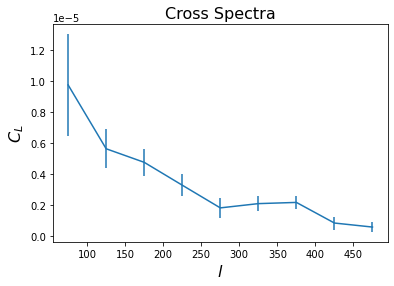

In [26]:
import matplotlib.pyplot as plt
plt.errorbar(binCenter[1:], bcls[1:], yerr = errBar[1:])
#plt.errorbar(binCenter[1:], bcls[1:], yerr = bcls_std[1:])
plt.title("Cross Spectra", fontsize = 16)
plt.xlabel(r'$l$', fontsize = 16)
plt.ylabel(r'$C_L$', fontsize = 16)
#plt.xticks((0, 100, 200, 300, 400, 500), fontsize = 12)
#plt.yticks((0, 0.5e-6, 1.0e-6, 1.5e-6, 2.0e-6), fontsize = 12)
#plt.xlim(0, 500)
#plt.ylim(0, 2e-6)

The signal-to-noise ratio is then given by
\begin{equation}
{\rm S/N} = \sqrt{\sum \frac{C_{L}^2}{\Delta C_L^2}}
\end{equation}

In [27]:
SN1 = np.sqrt(np.sum(bcls[1:]**2/errBar[1:]**2))
SN1

11.885335617860415

### Method II - Gaussian Errors
Under the assumption that in the $i-$th redshift bin, $a_{lm}$ are Gaussian random distributed variables, the covariance matrix of the angular cross-power spectrum is diagnoal, with the error given by
\begin{equation}
\Delta C_L = \sqrt{\frac{1}{(2L+1)f_{\rm sky}\Delta l}} \sqrt{[C^{\Phi}_{L}+N^{\Phi}_{L}][C^{\rm DES}_{L}+N^{\rm DES}_{L}] + (C^{\rm cross}_{L})^2}
\end{equation}
where we have 
* $f_{\rm sky}$, the sky fraction over which the weighting applied is nonzero, $f_{\rm sky}<1$
* $\Delta l$, the size of the bin
* $C^{\kappa\kappa}_{L}$ and $C^{\rm gg}_{L}$, the binned auto spectra of CMB potential and number overdensity
* $N^{\kappa\kappa}_{L}$ and $N^{\rm gg}_{L}$, the associated binned noise of CMB potential and number overdensity
* $C^{\rm cross}_{L}$, the binned cross spectra

We will calculate above variables in following steps and compare the error with Method I

#### Step 2 - Potential and Overdensity Power Spectrum
The $C^{\Phi}_{L}$ and $C^{\rm DES}_{L}$ can be obtained from CLASS. Here I load data file of CLASS output for these two observables.

In [28]:
df0 = pd.read_table('./Cls.dat', sep='\s+')
df0.head()

,1:l,2:TT,3:phiphi,4:TPhi,5:dens[1]-dens[1],6:phi-dens[1]
0,1,1.495443e-10,8.628904e-09,4.854772e-10,0.000001,7.294280e-08
1,2,1.495443e-10,8.628904e-09,4.854772e-10,0.000001,7.294280e-08
2,3,1.409376e-10,5.411292e-09,3.469574e-10,0.000003,9.148061e-08
3,4,1.324639e-10,3.776589e-09,2.639785e-10,0.000005,1.068559e-07
4,5,1.257529e-10,2.821984e-09,2.093816e-10,0.000008,1.200174e-07


Note that these output $C_l$ have the factor $l(l+1)/2\pi$, so I need to remove the factor

In [29]:
df0['3:phiphi'] = 2*np.pi*df0['3:phiphi']/(df0['1:l']*(df0['1:l']+1))
df0['5:dens[1]-dens[1]'] = 2*np.pi*df0['5:dens[1]-dens[1]']/(df0['1:l']*(df0['1:l']+1))
df0['6:phi-dens[1]'] = 2*np.pi*df0['6:phi-dens[1]']/(df0['1:l']*(df0['1:l']+1))

In [30]:
from orphics import cosmology

theory = cosmology.default_theory()
clkk = theory.gCl('kk',ells)

In [31]:
clpp = df0['3:phiphi'][:501].values
dclkk = (ells * (ells+1))**2 *clpp/4

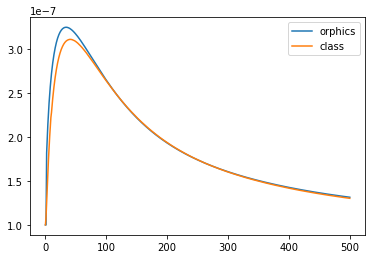

In [32]:
import matplotlib.pyplot as plt
plt.plot(ells, clkk+1e-7, label = 'orphics')
plt.plot(ells, dclkk+1e-7, label = 'class')
plt.legend()
#plt.plot(ells, kCls)

Text(0.5, 1.0, '$C_l^{gg}$ comparison')

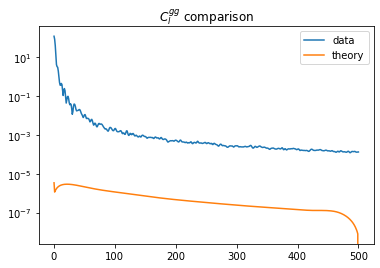

In [33]:
plt.plot(ells, gCls, label = 'data')
plt.plot(ells, df0['5:dens[1]-dens[1]'][:501].values, label = 'theory')
plt.legend()
plt.yscale('log')
plt.title(r'$C_l^{gg}$ comparison')

In [34]:
clpg = df0['6:phi-dens[1]'][:501].values
dclkg = ells * (ells+1) *clpg/2
#plt.plot(ells, dclkg)

Text(0, 0.5, '$C_L^{kg}$')

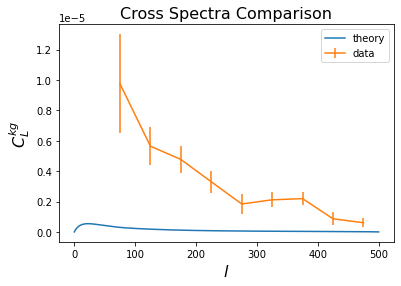

In [35]:
plt.plot(ells, dclkg, label = 'theory')
plt.errorbar(binCenter[1:], bcls[1:], yerr = errBar[1:], label = 'data')
plt.title("Cross Spectra Comparison", fontsize = 16)
plt.legend()
plt.xlabel(r'$l$', fontsize = 16)
plt.ylabel(r'$C_L^{kg}$', fontsize = 16)
#plt.xticks((0, 100, 200, 300, 400, 500), fontsize = 12)
#plt.yticks((0, 0.5e-6, 1.0e-6, 1.5e-6, 2.0e-6), fontsize = 12)
#plt.xlim(0, 500)
#plt.ylim(0, 2e-6)

Then we can get the binned $C_l$ for CMB potential, overdensity and the cross spectra. 

In [36]:
Cl_cmb = df0['3:phiphi'][:501].values

bcl_cmb, binedge, _ = binned_statistic(ells, dclkk, statistic = 'mean', bins = 10)
bcl_des, binedge, _ = binned_statistic(ells, df0['5:dens[1]-dens[1]'][:501].values, statistic = 'mean', bins = 10)
bcl_cor, binedge, _ = binned_statistic(ells, dclkg, statistic = 'mean', bins = 10)
del df0

In [37]:
n_g = nbar/(4*np.pi/hp.nside2npix(256)) # in steradian
n_g

1588753.3178624387

In [38]:
n_g/(180/np.pi*60)**2 # per acrmin^2 
# 0.03 per arcmin^2 BOSS
# 0.1-0.3 DES redmagic
# 5 DES maglim
# 10-50 HSC, LSST

0.13443387121245237

#### Step 3 - Getting error
Finally, I calculate the noise and get the error of cross spectra.

In [39]:
#n_g = nbar/(4*np.pi/hp.nside2npix(256)) # in steradian
N_cmb = 1e-7 * np.ones(10) 
N_des = 1/n_g * np.ones(10)
errbar2 = np.sqrt(1/((2 * binCenter + 1) * f_sky * 50)) * np.sqrt((bcl_cmb + N_cmb) * (bcl_des + N_des) + bcl_cor * bcl_cor)

Text(0, 0.5, '$C_L$')

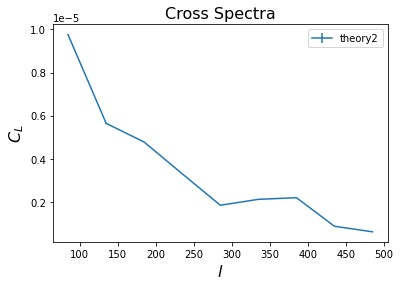

In [40]:
plt.errorbar(binCenter[1:]+10, bcls[1:], yerr = errbar2[1:], label = 'theory2')
#plt.errorbar(binCenter[1:]+10, bcls[1:], yerr = errBar[1:], label = 'scatter')
plt.title("Cross Spectra", fontsize = 16)
plt.legend()
plt.xlabel(r'$l$', fontsize = 16)
plt.ylabel(r'$C_L$', fontsize = 16)
#plt.xticks((0, 100, 200, 300, 400, 500), fontsize = 12)
#plt.yticks((0, 0.5e-6, 1.0e-6, 1.5e-6, 2.0e-6), fontsize = 12)
#plt.xlim(0, 500)
#plt.ylim(0, 2e-6)

In [41]:
# import pyfisher
# Get noise 
# ls,nell = pyfisher.get_lensing_nl('planck')
# from scipy.interpolate import interp1d
# nell_pl = interp1d(ls,nell,bounds_error=False,fill_value=0)(ells)